# Explaining a Self-Explaining Neural Network
---

<img src="img/SENN.png" alt="SENN Architecture Diagram (Alvarez-Melis \& Jaakkola)]" style="width: 640px;"/>

## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Computing the Jacobian with Pytorch Autograd

**How Autograd builds a computation graph?**
* Pytorch autograd engine is based on two major classes: ```Tensor``` and ```Function```
* Using these together, the autograd engine builds a computation graph
* Each ```Tensor``` has a ```.grad_fn``` attribute that records how it was generated
* A user-defined ```Tensor``` (a leaf node on the computation graph) has its ```.grad_fn``` set to ```None```
* A ```Tensor``` generated from an operation like ```+``` or ```*``` has its ```.grad_fn``` set to that ```Function``` operation

**How to compute gradients in the Autograd computation graph?**
* If the ```Tensor``` we want to compute the gradient against is a scalar, we simply call ```.backward()``` on it
* If the ```Tensor``` we want to compute the gradient against is multi-dimensional, we pass a gradient value to the ```.backward()``` method

In [2]:
def jacobian_demo(in_dim, out_dim):
    '''
    A Jacobian Demo:
    Set out_dim = 1 for default behaviour
    Set out_dim > 1 for magic
    '''
    x = torch.ones(in_dim, requires_grad=True)
    w = torch.randn((in_dim, out_dim))
    y = x@w
    print(f"x= {x}")
    print(f"W= {w}")
    print(f"y= {y}")

    if out_dim == 1:
        y.backward() # equivalent to y.backward(torch.tensor(1.))
    else:
        y.backward(torch.ones(out_dim))

    print(f"dy/dx = {x.grad}")

In [3]:
jacobian_demo(in_dim=3, out_dim=1)

x= tensor([1., 1., 1.], requires_grad=True)
W= tensor([[-0.1791],
        [-1.3889],
        [-0.8893]])
y= tensor([-2.4573], grad_fn=<SqueezeBackward3>)
dy/dx = tensor([-0.1791, -1.3889, -0.8893])


In [4]:
jacobian_demo(in_dim=3, out_dim=2)

x= tensor([1., 1., 1.], requires_grad=True)
W= tensor([[-1.0334, -0.5454],
        [-0.0359,  1.4675],
        [-0.4654,  1.1262]])
y= tensor([-1.5346,  2.0484], grad_fn=<SqueezeBackward3>)
dy/dx = tensor([-1.5788,  1.4317,  0.6609])


**PyTorch Autograd behind the scenes**
* Every node in the computation graph recieves the gradient from the node above it
* Autograd computes the product of the Jacobian of the current node with the incoming gradient vector
* So the grad of a node is computed as: $\mathbf{v}^{T} \cdot \mathbf{J}$
* For a scalar node, the incoming gradient vector is just a ```1 x 1``` vector
* The nodes after a scalar node then recieve the Jacobian of the scalar node w.r.t. to a vector as a ```out_dim x 1``` vector

In [5]:
batch = 1
num_features = 3
num_outputs = 2
x = torch.randn(batch, num_features)
print(x.shape)
w = nn.Parameter(torch.randn(num_features, num_outputs))
net = lambda x: x@w

torch.Size([1, 3])


In [6]:
x = x.squeeze()
n = x.size()[0]
x = x.repeat(num_outputs, 1)
x.requires_grad_(True)
print(x.shape)
y = net(x)
print(y.shape)
# step inside this call to see
y.backward(torch.eye(num_outputs))

torch.Size([2, 3])
torch.Size([2, 2])


In [7]:
print(x.grad.shape)

torch.Size([2, 3])


## Jacobian Function

In [8]:
def jacobian(f, x, out_dim):
    input = x.clone().detach()
    bsize = input.size()[0]
    # (bs, in_dim) --repeated--> (bs, out_dim, in_dim)
    input = input.unsqueeze(1).repeat(1, out_dim, 1)
    input.requires_grad_(True)
    # can only compute Jacobian of inputs and outputs with 2 dimensions
    out = f(input).reshape(bsize, out_dim, out_dim)
    # for autograd of non-scalar outputs
    grad_matrix = torch.eye(out_dim).reshape(1,out_dim, out_dim).repeat(bsize, 1, 1)
    out.backward(grad_matrix)
    return input.grad.data

## Test the Jacobian

In [9]:
class Net(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(in_dim, out_dim)
    
    def forward(self, x):
        return torch.nn.functional.relu(self.fc1(x))

In [10]:
batch = 2
num_features = 5
num_outputs = 2
x = torch.randn(batch, num_features)
print(x.shape)

torch.Size([2, 5])


In [11]:
f = Net(num_features, num_outputs)

In [12]:
f(x).shape

torch.Size([2, 2])

In [13]:
J = jacobian(f, x, num_outputs)
J, J.shape

(tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],
 
         [[-0.4382, -0.1372, -0.3710,  0.1570, -0.1364],
          [-0.3197,  0.0465, -0.1699,  0.3704, -0.1914]]]),
 torch.Size([2, 2, 5]))

## SENN as Linear Regression

In [14]:
bsize = 10
in_dim = 1
h_dim = in_dim # for the identity conceptizer case
out_dim = 1

In [15]:
def get_sine(bsize):
    x = torch.arange(0, 2*np.pi, 2*np.pi/bsize).unsqueeze(-1)
    y = torch.sin(x)
    return x, y

In [16]:
def get_line(bsize):
    x = torch.arange(0, 10, 10/bsize).unsqueeze(-1)
    y = 2*x
    return x, y

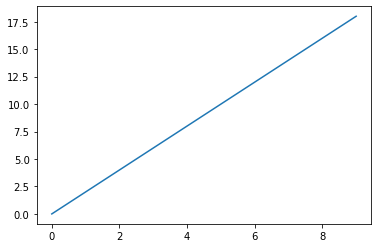

In [17]:
x,y = get_line(bsize)
plt.plot(x, y)
plt.show()

### Concepts

In [18]:
Conceptualizer = lambda x: x
concepts = Conceptualizer(x)
concepts.shape

torch.Size([10, 1])

### Relevances

In [38]:
w = nn.Parameter(torch.randn(in_dim, out_dim*h_dim))
Parameterizer = lambda x: (x@w) 
relevances = Parameterizer(x)
relevances.shape

torch.Size([10, 1])

### Aggregates

In [39]:
Aggregator = lambda x: (x[0]*x[1]).sum(1).unsqueeze(-1)
aggregates = Aggregator((relevances, concepts))
aggregates.shape

torch.Size([10, 1])

## SENN

### Conceptualizer

In [217]:
class Conceptualizer(nn.Module):
    
    def __init__(self):   super().__init__()
    def forward(self, x): return x

### Parameterizer

In [218]:
class Parameterizer(nn.Module):
    
    def __init__(self, in_dim, h_dim):
        super().__init__()
        self.W = nn.Linear(in_dim, h_dim)
    
    def forward(self, x):
        return self.W(x)

### Aggregator

In [219]:
class Aggregator(nn.Module):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, concepts, relevances):
        return (concepts + relevances)

In [220]:
import pdb

In [221]:
class SENN(nn.Module):
    
    def __init__(self, conceptualizer, parameterizer, aggregator):
        super().__init__()
        self.conceptualizer = conceptualizer
        self.parameterizer = parameterizer
        self.aggregator = aggregator
    
    def forward(self, x):
        concepts = self.conceptualizer(x)
        relevances = self.parameterizer(x)
#         pdb.set_trace()
        aggregates = self.aggregator(relevances,concepts)
        return aggregates, relevances, concepts

### Robustness Loss

$$\mathcal{L}_\theta := \| \nabla_{x} f(x) - \theta(x)^{T} J_{x}^{h}(x) \|$$

In [222]:
def regression_robustness_loss(x, relevances, senn):
    '''Robustness Loss formulation for Linear Regression Task'''
    # for linear regression
    # both num_classes (out_dim) and num_concepts (h_dim) is 1
    num_classes = relevances.size()[1]
    num_concepts = relevances.size()[1]
    relevances = relevances.reshape(-1,num_classes,num_concepts)
    
    def senn_aggregator(x): return senn(x)[0]
    def senn_conceptualizer(x): return senn.conceptualizer(x)
    
    J_yx = jacobian(senn_aggregator, x, num_classes)
    J_hx = jacobian(senn_conceptualizer, x, num_concepts)
    robustness_loss = (J_yx - torch.bmm(relevances, J_hx))

    return robustness_loss.norm(dim=(1,2)).mean()

### Regression Loss

In [223]:
mse_loss = nn.MSELoss()

### Reconstruction Loss

In [224]:
recon_loss = 0.

## Training

**Loss=** $\mathcal{L}_y (f(x), y) + \lambda \mathcal{L}_\theta (f) + \xi \mathcal{L}_h (x, \hat{x})$

In [225]:
num_epochs = 350
num_features = in_dim
num_classes = out_dim
num_concepts = h_dim
robust_lambda = 0.0

In [226]:
conceptualizer = Conceptualizer()
parameterizer = Parameterizer(num_features, num_concepts)
aggregator = Aggregator()
senn = SENN(conceptualizer, parameterizer, aggregator)

In [227]:
with torch.no_grad():
    aggregates, relevances, concepts = senn(x)

In [228]:
print(f"x: \t{x.squeeze().numpy()}")
print(f"concepts: \t{concepts.squeeze().numpy()}")
print(f"relevances: \t{relevances.squeeze().numpy()}")
print(f"aggregates: \t{aggregates.squeeze().numpy()}")
print(f"y: \t{y.squeeze().numpy()}")

x: 	[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
concepts: 	[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
relevances: 	[-0.8749522 -1.2409383 -1.6069244 -1.9729105 -2.3388968 -2.7048826
 -3.070869  -3.4368548 -3.8028412 -4.168827 ]
aggregates: 	[-0.8749522 -0.2409383  0.3930756  1.0270895  1.6611032  2.2951174
  2.929131   3.5631452  4.197159   4.831173 ]
y: 	[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]


In [229]:
senn.parameterizer.W.weight

Parameter containing:
tensor([[-0.3660]], requires_grad=True)

In [230]:
opt = optim.SGD(senn.parameters(), lr=0.0001)

In [231]:
for epoch in range(num_epochs):
    opt.zero_grad()
    aggregates, relevances, concepts = senn(x)
#     pdb.set_trace()
    regression_loss = mse_loss(aggregates, y) 
#     robustness_loss = regression_robustness_loss(x, relevances, senn)
#     loss = regression_loss + robust_lambda*robustness_loss + recon_loss
    
#     print(f"Loss:{loss.item():.3f} "
#           f"Regression:{regression_loss.item():.3f} "
#           f"Robustness: {robustness_loss.item():.3f}")
    regression_loss.backward()
    print(f"Regression:{regression_loss.item():.3f} ")
    opt.step()

Regression:64.701 
Regression:63.948 
Regression:63.204 
Regression:62.469 
Regression:61.743 
Regression:61.025 
Regression:60.315 
Regression:59.613 
Regression:58.920 
Regression:58.235 
Regression:57.558 
Regression:56.888 
Regression:56.227 
Regression:55.573 
Regression:54.927 
Regression:54.288 
Regression:53.657 
Regression:53.033 
Regression:52.416 
Regression:51.807 
Regression:51.204 
Regression:50.609 
Regression:50.021 
Regression:49.439 
Regression:48.864 
Regression:48.296 
Regression:47.735 
Regression:47.180 
Regression:46.632 
Regression:46.090 
Regression:45.554 
Regression:45.025 
Regression:44.501 
Regression:43.984 
Regression:43.473 
Regression:42.968 
Regression:42.468 
Regression:41.975 
Regression:41.487 
Regression:41.005 
Regression:40.528 
Regression:40.058 
Regression:39.592 
Regression:39.132 
Regression:38.678 
Regression:38.228 
Regression:37.784 
Regression:37.345 
Regression:36.911 
Regression:36.483 
Regression:36.059 
Regression:35.640 
Regression:3

In [232]:
senn.parameterizer.W.weight.item()

0.9114202260971069